# Tutorial: How to solve job shop scheduling problem by constraint programming with Google OR-Tools
Job shop scheduling problem (JSSP) is an optimization problem in computer science and operations research. In this context, each job comprises a sequence of tasks that must be executed in a specific order, with each task requiring processing on a designated machine. The common objective is to generate a schedule with minimal makespan. 

Constraint programming (CP) is a problem-solving approach that involves defining a problem as a set of limitations on potential solutions. This method utilizes constraints to reduce the possible values each variable can take, aiming to find feasible solutions within these constraints. Commonly used CP solvers are [IBM ILOG CPLEX Optimization](https://www.ibm.com/products/ilog-cplex-optimization-studio/cplex-cp-optimizer), [Google CP-SAT solver (integrated into Google OR-Tools)](https://developers.google.com/optimization/cp/cp_solver), [Gurobi](https://www.gurobi.com/).

This tutorial shows how to use Google OR-Tools to build a constraint model and run the solver. It's based on the example in [Google OR-Tools documentation](https://developers.google.com/optimization/scheduling/job_shop). 

New features include:

- Parser for benchmark dataset to test the performance to solve large scale instances.
- Gantt chart visualization to plot the schedule.

Now let's get start!

## Problem description
The job shop problem can be described as follows:
There are $m$ heterogeneous machines in a factory. One day the factory received $n$ jobs, each of which consists of a set of $p$ tasks (as known as operation) which need to be process in a specific order. Each task has a specific machine that it needs to be processed on. 

Here are several constraints for the job shop problem:
- No task for a job can start until the previous task is completed.
- Each machine can work on only one task at a time.
- Once a task begins, it must run to completion.

We need to generate a schedule to decide the start time of each task with minimal makespan. 

## Import libraries
Please make sure the following libraries have been installed. 
- [Google OR-Tools](https://developers.google.com/optimization)
- [Python library for Google Chart API](https://github.com/google/google-visualization-python) 
- [matplotlib](https://matplotlib.org/)

In [ ]:
%pip install ortools # Google OR-Tools
%pip install gviz_api # A helper python library for Google Chart API 
%pip install matplotlib # matplotlib

Import the constraint programming from Google OR-Tools and built-in packages. 

In [14]:
import collections
from ortools.sat.python import cp_model

## Prepare data
We can start from a simple example to understand the problem itself and workflow the solver. After that we can try to load large-scale instances and test the performance of the solver. 

### Example problem
Here is an example of a job shop problem of 3 jobs. Within each job, the task is labeled by a pair of numbers (m,d) where m is the machine the task must be processed on and d is the processing time of the task. The numbering of jobs and machines starts at 0.

- job 0 = [(0, 3), (1, 2), (2, 2)]
- job 1 = [(0, 2), (2, 1), (1, 4)]
- job 2 = [(1, 4), (2, 3)]

In the example, job 0 has three tasks. The first, (0, 3), must be processed on machine 0 in 3 units of time. The second, (1, 2), must be processed on machine 1 in 2 units of time, and so on. Altogether, there are eight tasks.

Horzion refers to the sum of processing time of all tasks, which is used as the upper bound for decision variables. 


In [2]:
jobs_data = [  # task = (machine_id, processing_time).
    [(0, 3), (1, 2), (2, 2)],  # Job0
    [(0, 2), (2, 1), (1, 4)],  # Job1
    [(1, 4), (2, 3)],  # Job2
]

machines_count = 1 + max(task[0] for job in jobs_data for task in job)
all_machines = range(machines_count) 
# Computes horizon dynamically as the sum of all durations.
horizon = sum(task[1] for job in jobs_data for task in job)
# Print the summary of this instance
print(f"Number of jobs: {len(jobs_data)},Number of machines: {machines_count}, Planning horizon: {horizon}")

### Load instance from benchmark dataset
We can also load the problem instance from benchmark dataset. There are several well-known benchmark dataset, such as Taillard, Demirkol's, etc. These instances are in `./dataset/jsp`. The format can refer to [Large-Scale Benchmarks for the Job Shop Scheduling Problem](http://arxiv.org/abs/2102.08778). 

In [49]:
def jsp_parser(filepath: str) -> dict:
    import os

    if not os.path.exists(filepath):
        raise FileNotFoundError("Invalid file path. ")
    data = []
    with open(filepath) as f:
        lines = f.readlines()
        cur_line = 0
        while lines[cur_line].startswith("#"):# skip the header
            cur_line += 1

        # read the number of jobs and machines
        num_jobs, num_machines = list(map(int,lines[cur_line].split()))
        cur_line += 1
        # read the jobs data
        for line in lines[cur_line:]:
            numbers = list(map(int,line.split()))
            data.append([
                (numbers[i],numbers[i+1])
                for i in range(0,len(numbers),2)
            ])
        return data
                

jobs_data= jsp_parser("./jsp_dataset/abz5")

machines_count = 1 + max(task[0] for job in jobs_data for task in job)
all_machines = range(machines_count) 
# Computes horizon dynamically as the sum of all durations.
horizon = sum(task[1] for job in jobs_data for task in job)
# Print the summary of this instance
print(f"Number of jobs: {len(jobs_data)},Number of machines: {machines_count}, Planning horizon: {horizon}")

FileNotFoundError: Invalid file path. 

## Declare the model
The following code declares a constraint model. 

In [41]:
model = cp_model.CpModel()

### Define the variables

For each job and task, the variables for start and finish time are created.
- $s_{j,t} \in \{0, ..., H\}$ ,the start time for task $t$ of job $j$, integer variable, $H$ refers to horizon, the sum processing time of all tasks.
- $f_{j,t} \in \{0,..., H\}$ ,the finish time for task $t$ of job $j$, integer variable, $H$ refers to horizon, the sum processing time of all tasks.

In addition, a special typle of interval variables which is also a constraint- is defined to bridge the above variables. That is, for each task, $s_{j,t} + d_{j,t} == f_{j,t}$ 

In [42]:
# Named tuple to store information about created variables.
task_type = collections.namedtuple("task_type", "start end interval")
# Named tuple to manipulate solution information.
assigned_task_type = collections.namedtuple(
    "assigned_task_type", "start job index duration"
)

# Creates job intervals and add to the corresponding machine lists.
all_tasks = {}
machine_to_intervals = collections.defaultdict(list)

for job_id, job in enumerate(jobs_data):
    for task_id, task in enumerate(job):
        machine, duration = task
        suffix = f"_{job_id}_{task_id}"
        start_var = model.new_int_var(0, horizon, "start" + suffix)
        end_var = model.new_int_var(0, horizon, "end" + suffix)
        interval_var = model.new_interval_var(
            start_var, duration, end_var, "interval" + suffix
        )
        all_tasks[job_id, task_id] = task_type(
            start=start_var, end=end_var, interval=interval_var
        )
        machine_to_intervals[machine].append(interval_var)

### Define the constraints

There are two types of constraints:
- **Overlap constraints**: Each machine can only work on one task at a time. This is enusred by adding overlap constraints for each machine.
- **Precedence constraints**: A task can only start after any preceeding tasks has been completed, i.e. $s_{j,t+1} >= f_{j,t}$

In [ ]:
# Create and add disjunctive constraints.
for machine in all_machines:
    model.add_no_overlap(machine_to_intervals[machine])

# Precedences inside a job.
for job_id, job in enumerate(jobs_data):
    for task_id in range(len(job) - 1):
        model.add(
            all_tasks[job_id, task_id + 1].start >= all_tasks[job_id, task_id].end
        )

### Define the objective

The makespan of a schedule is the max of the end of all jobs. 

$\text{makespan} = max\{f_{j,T_j},...\}$, where $T_j$ is the last task of job $j$

The objective is to minimize the makespan, i.e. 

$minimize \quad \text{makespan}$

In [44]:
# Makespan objective.
obj_var = model.new_int_var(0, horizon, "makespan")
model.add_max_equality(
    obj_var,
    [all_tasks[job_id, len(job) - 1].end for job_id, job in enumerate(jobs_data)],
)
model.minimize(obj_var)

## Run the solver
Now we can run the solver. It might take longer with large-scale instances. 

In [45]:
solver = cp_model.CpSolver()
status = solver.solve(model)

Let's check the results!

In [ ]:
if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    print("Solution:")
    # Create one list of assigned tasks per machine.
    assigned_jobs = collections.defaultdict(list)
    for job_id, job in enumerate(jobs_data):
        for task_id, task in enumerate(job):
            machine = task[0]
            assigned_jobs[machine].append(
                assigned_task_type(
                    start=solver.value(all_tasks[job_id, task_id].start),
                    job=job_id,
                    index=task_id,
                    duration=task[1],
                )
            )

    # Create per machine output lines.
    output = ""
    for machine in all_machines:
        # Sort by starting time.
        assigned_jobs[machine].sort()
        sol_line_tasks = "Machine " + str(machine) + ": "
        sol_line = "           "

        for assigned_task in assigned_jobs[machine]:
            name = f"job_{assigned_task.job}_task_{assigned_task.index}"
            # add spaces to output to align columns.
            sol_line_tasks += f"{name:15}"

            start = assigned_task.start
            duration = assigned_task.duration
            sol_tmp = f"[{start},{start + duration}]"
            # add spaces to output to align columns.
            sol_line += f"{sol_tmp:15}"

        sol_line += "\n"
        sol_line_tasks += "\n"
        output += sol_line_tasks
        output += sol_line

    # Finally print the solution found.
    print(f"Optimal Schedule Length: {solver.objective_value}")
    print(output)
else:
    print("No solution found.")

Solution:
Optimal Schedule Length: 5183.0
Machine 0: job_56_task_0  job_44_task_1  job_94_task_0  job_12_task_1  job_92_task_3  job_53_task_2  job_9_task_3   job_19_task_3  job_50_task_2  job_36_task_2  job_83_task_5  job_35_task_7  job_14_task_2  job_59_task_3  job_0_task_5   job_4_task_6   job_85_task_2  job_82_task_3  job_70_task_6  job_75_task_2  job_43_task_5  job_17_task_3  job_90_task_3  job_84_task_4  job_62_task_7  job_2_task_7   job_71_task_8  job_76_task_6  job_45_task_9  job_27_task_8  job_91_task_10 job_22_task_9  job_31_task_3  job_77_task_8  job_25_task_6  job_63_task_6  job_23_task_8  job_96_task_6  job_28_task_8  job_34_task_14 job_46_task_9  job_86_task_10 job_18_task_8  job_10_task_11 job_57_task_10 job_7_task_8   job_67_task_8  job_61_task_8  job_33_task_13 job_32_task_9  job_41_task_14 job_40_task_10 job_58_task_15 job_8_task_13  job_68_task_16 job_39_task_13 job_97_task_11 job_11_task_15 job_66_task_11 job_88_task_14 job_60_task_16 job_99_task_14 job_42_task_13 jo

## Plot schedule
Now we can plot this schedule. There are two implementation. 
One uses Google Chart API, which requires internet access to Google. 
You might need to wait several seconds to load the js library. 
If no chart displays, please use the alternative methods with matplotlib.

### Plot with Google Chart API

In [ ]:
import gviz_api
from IPython.display import display, HTML

page_template = """
<html>
  <script src="https://www.gstatic.com/charts/loader.js"></script>
  <script>
    google.charts.load('current', {packages:['timeline']});

    google.charts.setOnLoadCallback(drawTable);
    function drawTable() {
      var json_table = new google.visualization.Timeline(document.getElementById('table_div_json'));
      var json_data = new google.visualization.DataTable(%(json)s, 0.6);
      var options = {
        colors: %(color_series)s,
        //tooltip:{trigger: 'none'}
        
      }
      json_table.draw(json_data, options);
    }
  </script>
  <body>
    <H1>Gantt Chart</H1>
    <div id="table_div_json" style="background-color: white;"></div>
  </body>
</html>
"""

def plot_google_chart(assigned_jobs: dict):
  # Creating the data scheme
  description = {"machine": ("string", "Machine"),
                 "task": ("string", "Task"),
                 "start": ("number", "Start"),
                 "end": ("number", "End"),
                 }


  data = []
  color_series = []
  color_palettes = ["#4285f4", "#e94436", "#34a853"] # the colors for the tasks. tasks from the same job have the same color.
  num_colors = len(color_palettes)
  for machine_id, tasks in assigned_jobs.items():
    for task in tasks:
      data.append(
        {"machine":f"Machine {machine_id}",
        "task": f"job({task.job},{task.index})",
          "start":task.start,
          "end": task.start+task.duration}
      )
      color = color_palettes[task.job % num_colors]
      color_series.append(color)
  # Loading it into gviz_api.DataTable
  data_table = gviz_api.DataTable(description)
  data_table.LoadData(data)

  # Create a JSON string.
  json = data_table.ToJSon(columns_order=("machine", "task", "start","end"),
                               order_by="machine")
  


  # Put the JS code and JSON string into the template.
  display(HTML(page_template % vars()))

plot_google_chart(assigned_jobs)

### Plot with matplotlib

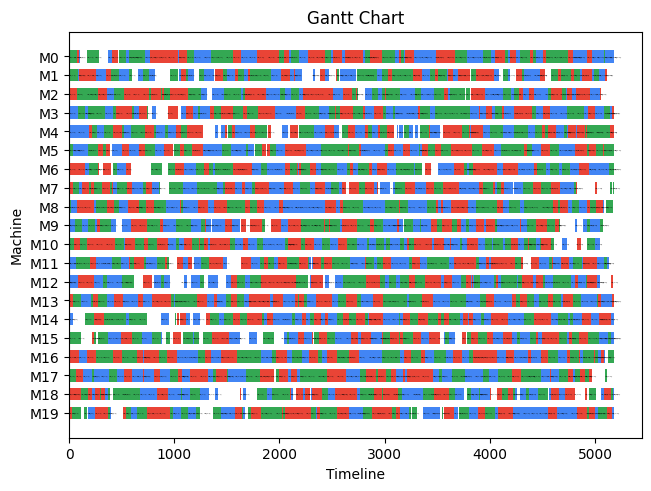

In [ ]:
from matplotlib import pyplot as plt


def plot_schedule_matplotlib(assigned_jobs: dict):
    fig, ax = plt.subplots(layout="constrained")
    # figure configuration 
    bar_width = 2 # the width of the bar
    text_size = 8 # text size for the label for each bar block
    machine_gap = 3 # the gap in-between each machine
    color_palettes = ["#4285f4", "#e94436", "#34a853"] # the colors for the tasks. tasks from the same job have the same color.
    num_colors = len(color_palettes) 

    # process the data for plotting
    num_machiens = len(assigned_jobs)
    for machine_id, tasks in assigned_jobs.items():
        data = []
        color_series = []
        for task in tasks:
            data.append((task.start, task.duration)) #  data for ploting bar
            color_series.append(color_palettes[task.job % num_colors]) # color for this task. tasks from the same job have the same color.
            plt.text( # add text on the bar
                task.start + 0.1,
                ((num_machiens - machine_id + 1) * machine_gap + bar_width * 0.5),
                f"job({task.job},{task.index})",
                fontsize=text_size,
            )

        ax.broken_barh( # plot a horizontal bar
            data,
            ((num_machiens - machine_id + 1) * machine_gap, bar_width),
            facecolors=color_series,
        )
    # settings for x/y axes
    plt.yticks(
        [
            ((num_machiens - machine_id + 1) * machine_gap + bar_width * 0.5)
            for machine_id in range(num_machiens)
        ],
        [f"M{machine_id}" for machine_id in range(num_machiens)],
    )
    plt.xlabel("Timeline")
    plt.ylabel("Machine")
    plt.xlim(left=0)
    plt.title("Gantt Chart")


plot_schedule_matplotlib(assigned_jobs)

## Acknowledgement

This tutorial draws on a number of existing projects/code/documentation and includes a list of acknowledgements below.
- [Google OR-Tools](https://developers.google.com/optimization/scheduling/job_shop)
- [GitHub Project: An Efficient Approach for Solving Large Scale Flexible Job Shop Scheduling Problem: A Strategic Constraint Programming](https://github.com/MansourZarrin/Flexible-Job-Shop-Scheduling-Problem-Constraint-Programming)
- [GitHub Project: JSPLIB](https://github.com/tamy0612/JSPLIB/tree/master)
- [ND Pyomo Cookbook - 4.3. Job Shop Scheduling](https://jckantor.github.io/ND-Pyomo-Cookbook/notebooks/04.03-Job-Shop-Scheduling.html)